In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

We will be solving 2D constant velocity advection equation using non-interpolating semi-lagrange techniques with periodic boundary conditions.

In [2]:
# Parameters
N = 101 # Number of grid points in each direction
v = [1.65, 2.56] # Velocity in x and y directions
dt = 1 # Time step size
T = 1000 # Number of timesteps

In [3]:
# grid to store states for each timestep
grid = np.zeros((T, N, N))

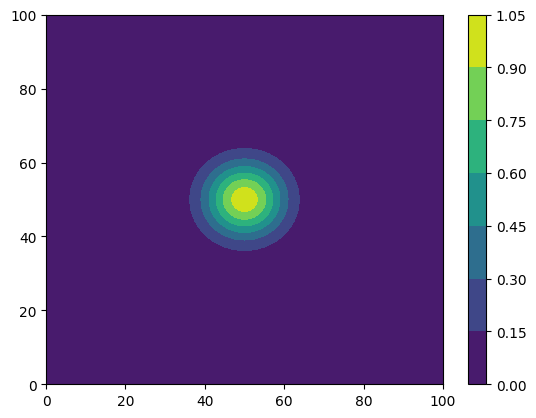

In [4]:
# initial condtions
x = np.linspace(-(N-1)//2, (N-1)//2, N)
y = np.linspace(-(N-1)//2, (N-1)//2, N)
x_grid, y_grid = np.meshgrid(x, y)

grid[0, :, :] = np.exp(-((x_grid/10)**2 + (y_grid/10)**2))
#grid[1, :, :] = np.exp((-((x-v_x*dt)/10)**2 - ((y-v_y*dt)/10)**2))

cp = plt.contourf(grid[0, :, :])
plt.colorbar(cp)
plt.show()

In [ ]:
# velocity interpolator
def velocity_interp(timestep, shift): # TO DO LATER
    vel_mat = np.zeros((1, len(x)))
    vel_mat += v
    return np.roll(vel_mat, int(shift))

# finite difference differentiator 
def shifted_diff(timestep, shift):
    if shift.is_integer():
        diff_mat = (np.roll(grid[timestep, :], int(shift - 1)) - np.roll(grid[timestep, :], int(shift + 1)))/2
    else:
        diff_mat = (np.roll(grid[timestep, :], int(shift - 0.5)) - np.roll(grid[timestep, :], int(shift + 0.5)))
    return diff_mat

# Fourier space differentiator
def shifted_diff_fourier(timestep, shift):
    # Fourier transform of the grid at the given timestep
    grid_fft = np.fft.fft(grid[timestep, :])
    
    # Generate a frequency array
    N = len(grid[timestep, :])
    k = np.fft.fftfreq(N, d=1)  # Assuming unit spacing
    
    # Apply the derivative in Fourier space (i*k shifts the phase)
    derivative_fft = 1j * k * grid_fft
    
    # Inverse Fourier transform to get back to spatial domain
    diff_mat = np.fft.ifft(derivative_fft).real
    
    # Shift the result as needed
    diff_mat = np.roll(diff_mat, int(shift))
    
    return diff_mat

# starting point
def starting_point(velocity):
    return int(round(2*velocity))

# Noninterpolating Semi-Lagrangian, gives us the value of x at the starting point for the next timestep
def semi_lagrange_noninterp(timestep, grid_array, p):
    shifted_t_1_array = np.roll(grid_array[timestep - 1, :], p)
    grid_array[timestep + 1, :] = shifted_t_1_array + (p/2 - velocity_interp(timestep, p/2))*shifted_diff_fourier(timestep, p/2)